# **GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

Thu Aug  8 14:17:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install**

In [ ]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Init**

In [ ]:
num_cls = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

# **Dataset 🗂️**

## Transform

In [ ]:
transform_train = T.Compose([T.RandomCrop(32, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                 std=(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                std=(0.2023, 0.1994, 0.2010))])

## CIFAR Dataset

In [ ]:
train_set = CIFAR10(root='./deep-learning-2022-howsam/cifar10', train=True,
                                 download=True,
                                 transform=transform_train)

test_set = CIFAR10(root='./deep-learning-2022-howsam/cifar10', train=False,
                                download=True,
                                transform=transform_test)

100%|██████████| 170498071/170498071 [00:19<00:00, 8734748.91it/s] 


Extracting ./deep-learning-2022-howsam/cifar10/cifar-10-python.tar.gz to ./deep-learning-2022-howsam/cifar10
Files already downloaded and verified


In [ ]:
train_set.data.shape

(50000, 32, 32, 3)

## DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([0, 9, 5, 2, 4, 0, 6, 8, 7, 9, 3, 1, 6, 1, 5, 8, 2, 5, 6, 2, 5, 7, 4, 8,
        3, 5, 6, 5, 3, 5, 9, 3, 9, 5, 0, 2, 3, 3, 2, 6, 4, 4, 5, 4, 7, 9, 0, 8,
        7, 6, 6, 5, 6, 9, 4, 4, 1, 2, 5, 4, 4, 1, 5, 8])


## Visualize

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

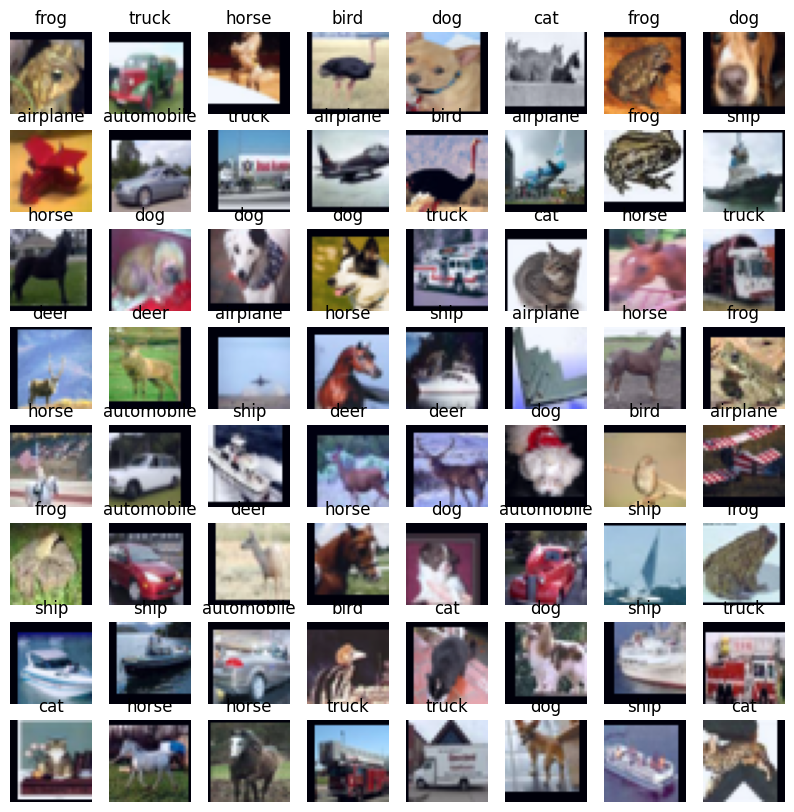

In [ ]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [ ]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [ ]:
def Teacher():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [ ]:
def Student():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [ ]:
teacher = Teacher().to(device)
num_params(teacher)

4.694346

In [ ]:
student = Student().to(device)
num_params(student)

1.558026

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_cls).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [52]:
def train_one_epoch_kd(student, teacher, train_loader, loss_fn, optimizer, epoch=None):
  student.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = student(inputs)
      with torch.no_grad():
        teacher_outputs = teacher(inputs)

      loss = loss_fn(outputs, targets, teacher_outputs, T=10, alpha=0.6)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return student, loss_train.avg, acc_train.compute().item()

# **Train Teacher & Student Models 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
model = Teacher().to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3081, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set) - 500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = Teacher().to(device)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:01<00:00, 24.54batch/s, accuracy=100, loss=0.000911]


## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 3
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = Teacher().to(device)
  # model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 1:  67%|██████▋   | 527/782 [00:32<00:15, 16.42batch/s, accuracy=33.8, loss=1.76]


KeyboardInterrupt: 

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]:
  for wd in [1e-4, 1e-5, 0.]:
    model = Teacher().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

## Step 5: train more epochs

In [ ]:
model = Teacher().to(device)

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'teacher.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:49<00:00, 15.68batch/s, accuracy=56, loss=1.21]


Model Saved!
Valid: Loss = 1.128, Acc = 0.6294



Epoch 1: 100%|██████████| 782/782 [00:48<00:00, 16.12batch/s, accuracy=72.9, loss=0.776]


Model Saved!
Valid: Loss = 0.7602, Acc = 0.7445



Epoch 2: 100%|██████████| 782/782 [00:48<00:00, 16.07batch/s, accuracy=78.2, loss=0.631]


Model Saved!
Valid: Loss = 0.669, Acc = 0.7796



Epoch 3: 100%|██████████| 782/782 [00:47<00:00, 16.35batch/s, accuracy=80.7, loss=0.55]


Valid: Loss = 0.7429, Acc = 0.7534



Epoch 4: 100%|██████████| 782/782 [00:48<00:00, 16.19batch/s, accuracy=82.8, loss=0.494]


Model Saved!
Valid: Loss = 0.513, Acc = 0.8292



Epoch 5: 100%|██████████| 782/782 [00:46<00:00, 16.95batch/s, accuracy=84.7, loss=0.44]


Valid: Loss = 0.606, Acc = 0.8008



Epoch 6: 100%|██████████| 782/782 [00:48<00:00, 16.00batch/s, accuracy=85.9, loss=0.405]


Model Saved!
Valid: Loss = 0.4641, Acc = 0.8423



Epoch 7: 100%|██████████| 782/782 [00:48<00:00, 16.14batch/s, accuracy=87.1, loss=0.371]


Model Saved!
Valid: Loss = 0.4441, Acc = 0.85



Epoch 8: 100%|██████████| 782/782 [00:48<00:00, 16.26batch/s, accuracy=88.1, loss=0.344]


Valid: Loss = 0.4534, Acc = 0.848



Epoch 9: 100%|██████████| 782/782 [00:47<00:00, 16.36batch/s, accuracy=88.9, loss=0.319]


Valid: Loss = 0.4533, Acc = 0.8499



Epoch 10: 100%|██████████| 782/782 [00:46<00:00, 16.76batch/s, accuracy=89.6, loss=0.299]


Valid: Loss = 0.4866, Acc = 0.8468



Epoch 11: 100%|██████████| 782/782 [00:45<00:00, 17.32batch/s, accuracy=90.1, loss=0.287]


Model Saved!
Valid: Loss = 0.3733, Acc = 0.8773



Epoch 12: 100%|██████████| 782/782 [00:44<00:00, 17.67batch/s, accuracy=90.8, loss=0.264]


Valid: Loss = 0.4002, Acc = 0.8728



Epoch 13: 100%|██████████| 782/782 [00:47<00:00, 16.45batch/s, accuracy=91.3, loss=0.251]


Valid: Loss = 0.3909, Acc = 0.8746



Epoch 14: 100%|██████████| 782/782 [00:47<00:00, 16.53batch/s, accuracy=91.7, loss=0.237]


Valid: Loss = 0.3826, Acc = 0.8793



# **Train Knowledge Distillation 👨**

## Knowledge distillation loss

Class doc: [link](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)

functional doc: [link](https://pytorch.org/docs/stable/generated/torch.nn.functional.kl_div.html)

In [ ]:
def loss_fn_kd(outputs, labels, teacher_outputs, T, alpha):
  loss = F.kl_div(F.log_softmax(outputs / T, dim=1),
                  F.softmax(teacher_outputs / T, dim=1),
                  reduction='batchmean') * (alpha * T ** 2) + \
                  F.cross_entropy(outputs, labels) * (1 - alpha)
  return loss

In [ ]:
loss_fn_kd(torch.randn(3, 5),
           torch.tensor([1, 2, 3]),
           torch.randn(3, 5),
           T=10,
           alpha=0.6)

tensor(2.3289)

## Train

In [55]:
teacher = torch.load('teacher.pt')
teacher.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): S

In [56]:
student = Student().to(device)

In [57]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(student.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [58]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [59]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  student, loss_train, acc_train = train_one_epoch_kd(student,
                                                      teacher,
                                                      train_loader,
                                                      loss_fn_kd,
                                                      optimizer,
                                                      epoch)
  # Validation
  loss_valid, acc_valid = validation(student,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Save!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:46<00:00, 16.74batch/s, accuracy=53.9, loss=3.93]


Model Save!
Valid: Loss = 1.24, Acc = 0.6545



Epoch 1: 100%|██████████| 782/782 [00:44<00:00, 17.70batch/s, accuracy=70.9, loss=2.01]


Model Save!
Valid: Loss = 0.9278, Acc = 0.727



Epoch 2: 100%|██████████| 782/782 [00:44<00:00, 17.38batch/s, accuracy=76.1, loss=1.51]


Model Save!
Valid: Loss = 0.86, Acc = 0.7444



Epoch 3: 100%|██████████| 782/782 [00:45<00:00, 17.17batch/s, accuracy=79.3, loss=1.24]


Model Save!
Valid: Loss = 0.6617, Acc = 0.7995



Epoch 4: 100%|██████████| 782/782 [00:44<00:00, 17.74batch/s, accuracy=81.1, loss=1.07]


Valid: Loss = 0.7992, Acc = 0.7776



Epoch 5: 100%|██████████| 782/782 [00:45<00:00, 17.14batch/s, accuracy=82.6, loss=0.96]


Model Save!
Valid: Loss = 0.6216, Acc = 0.8033



Epoch 6: 100%|██████████| 782/782 [00:46<00:00, 16.89batch/s, accuracy=83.7, loss=0.879]


Model Save!
Valid: Loss = 0.5388, Acc = 0.8267



Epoch 7: 100%|██████████| 782/782 [00:47<00:00, 16.45batch/s, accuracy=84.5, loss=0.823]


Valid: Loss = 0.5985, Acc = 0.8126



Epoch 8: 100%|██████████| 782/782 [00:47<00:00, 16.60batch/s, accuracy=85.1, loss=0.782]


Valid: Loss = 0.5472, Acc = 0.8297



Epoch 9: 100%|██████████| 782/782 [00:46<00:00, 16.66batch/s, accuracy=85.4, loss=0.755]


Model Save!
Valid: Loss = 0.5332, Acc = 0.8303



Epoch 10: 100%|██████████| 782/782 [00:45<00:00, 17.08batch/s, accuracy=86.1, loss=0.711]


Model Save!
Valid: Loss = 0.4922, Acc = 0.841



Epoch 11: 100%|██████████| 782/782 [00:43<00:00, 17.78batch/s, accuracy=86.5, loss=0.692]


Model Save!
Valid: Loss = 0.4477, Acc = 0.8554



Epoch 12: 100%|██████████| 782/782 [00:44<00:00, 17.74batch/s, accuracy=86.9, loss=0.664]


Model Save!
Valid: Loss = 0.4467, Acc = 0.859



Epoch 13: 100%|██████████| 782/782 [00:43<00:00, 17.93batch/s, accuracy=87.1, loss=0.644]


Model Save!
Valid: Loss = 0.4274, Acc = 0.8616



Epoch 14: 100%|██████████| 782/782 [00:43<00:00, 17.90batch/s, accuracy=87.7, loss=0.627]


Valid: Loss = 0.4471, Acc = 0.856



# **Plot**

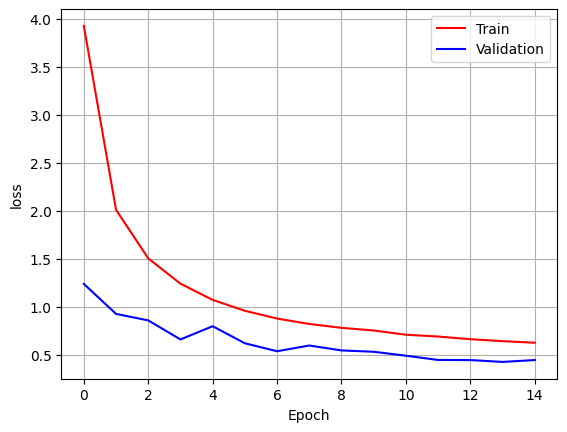

In [60]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

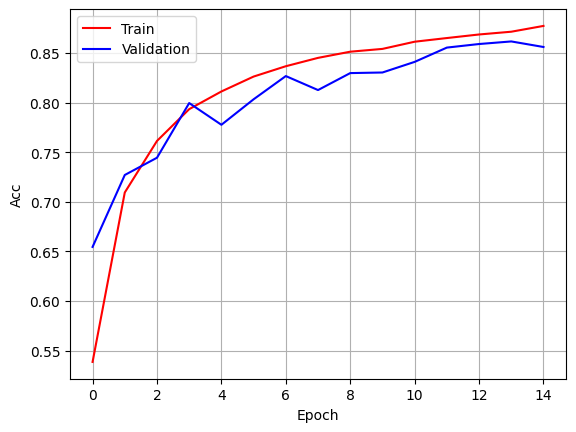

In [61]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()